In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits, ascii
from dustmaps.config import config
from scipy.optimize import curve_fit 
import pandas as pd
import os
config.reset()

In [2]:
# Function to call coordinates and return distance axis and differential Av. To get total Av along a line a sight try np.sum(cdusts)*delta(dists).

def dust(l, b):
    # Return distance, differential Av along a line of sight provided:
    dists = np.linspace(100, 800, 100)
    cdusts = np.zeros_like(dists)
    for i, d in enumerate(dists):
        if (i != 0): 
            point = SkyCoord(l*u.deg, b*u.deg, distance=d*u.pc, frame='galactic')
            data, flags = b19.query(point, mode='mean', return_flags=True)
            cdusts[i]=data
    #dists = dists/1000 #pc to kpc conversion
    cdusts = cdusts-np.roll(cdusts, 1)
    return dists, cdusts

In [3]:
# You may have to download this map and it will take a long time. See dustmaps documentation.
import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [4]:
def distmod_to_dist(distmod):
    return 10**(1 + distmod / 5)
# Change modulus to distance

In [5]:
# Load the Bayestar 19 dustmap
b19 = dustmaps.bayestar.BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 14.956 s
  pix_info:   0.341 s
   samples:   4.983 s
      best:   2.613 s
       nan:   0.019 s
      sort:   6.922 s
       idx:   0.079 s


In [6]:
#Gaussian function, h = height, c = center, w = width 
def Gauss(x, h, c, w): 
    G = h*np.exp(-(x-c)**2/(2*w**2))
    return G

In [7]:
def plotred(l, b, bounds = (-np.inf, np.inf)):
    
    """Plot the differential reddening for a given Galactic coordinate (l, b)."""
    dists, cdusts = dust(l, b)
    cdusts = cdusts * 3.1 #multiply by Rv factor

    max_Av = np.abs(cdusts[0])
    max_Av2 = np.max(cdusts) #using this so we can find where Av is approximately max, workaround for max_Av yielding an empty array
    max_Av_loc = dists[np.where(cdusts == max_Av2)] #location of highest col dens

    #Gaussian fitting portion
    x = np.linspace(np.min(dists), np.max(dists), 100) #x value for gaussian to plot along
    parsec_data = np.array(cdusts) #ensure array
    Av_data = np.array(dists) #extinction data
    parameters, covariance = curve_fit(Gauss, dists, cdusts, p0=[.2, float(max_Av_loc[0]), 50], bounds = bounds) #max Av loc is location of dust peak, of which we use as center
    fit_h = parameters[0] #height
    fit_c = parameters[1] #center
    fit_w = parameters[2] #width
    fit_y = Gauss(x, fit_h, fit_c, fit_w)
    #print('FWHM', fit_w)

    #Calculations
    ratio = 8.3e21 * u.cm**-2 * u.mag**-1 #Number from Listz 2014a (sec 4.2 of Nguyen 2018 "Dust-Gas Scaling Relations"
    Av = max_Av*u.mag #maximum extinction
    NH = ratio*Av #Column density
    depth = float(fit_w)*u.pc #FWHM of gaussian = depth
    volumeDensity = NH/depth
    volumeDensity = volumeDensity.to('cm**-3')

    #pandas dataframe
    data = {
        'l': [l],
        'b': [b],
        'Max Av [mag]': [max_Av],
        'Distance of Max Av [pc]': [max_Av_loc],
        'FWHM [pc]': [fit_w],
        'Column Density [cm^-2]': [NH.value],
        'Volume Density [cm^-3]': [volumeDensity.value]
    }
    df = pd.DataFrame(data)


    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts, where='mid', label = 'Data')
    ax.step(x, fit_y, linestyle = '--', color = 'crimson', label = 'Gaussian Fit')
    ax.set_xlabel('Distance (pc)', size=12)
    ax.set_ylabel(r'$\Delta$ A$_{\mathrm{v}}$ [mag]', size=12)
    ax.set_title(f'Differential Av Towards l={l}, b={b}', size=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([0, 1])
    ax.legend()
    plt.grid(True, linestyle = '--')
    plt.show()


    folder = "B19 Mapped Dust Outputs"
    filename = os.path.join(folder, f"Bayestar19_l{l}_b{b}_mapped.csv")
    df.to_csv(filename, index=False)

    return df

    #print('Max Av is', max_Av, 'mag')
    #print('Max Av is at distance', max_Av_loc, 'pc')
    #print('Volume Density is:', volumeDensity)
    #print(cdusts)

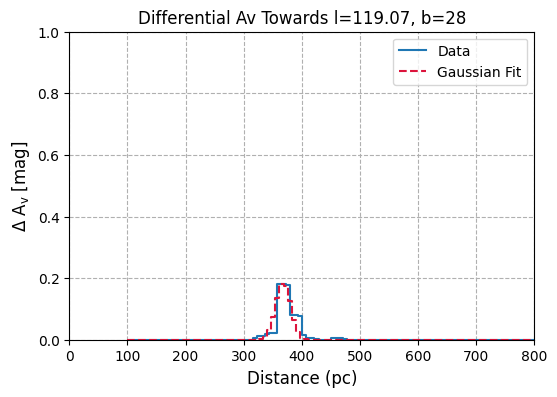

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,119.07,28,0.9145,[368.6868686868687],12.682197,7.590350e+21,193.96206


In [8]:
plotred(119.07, 28)

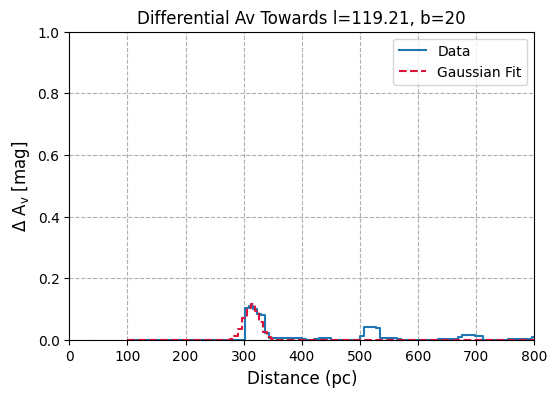

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,119.21,20,0.875663,[312.1212121212121],12.935086,7.268003e+21,182.093841


In [9]:
plotred(119.21, 20)

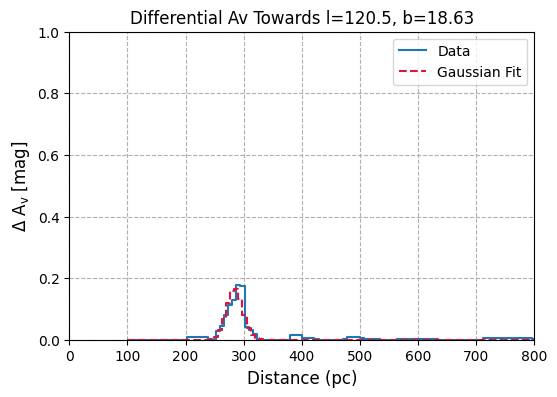

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,120.5,18.63,1.086916,[290.9090909090909],13.880925,9.021401e+21,210.622631


In [10]:
plotred(120.5, 18.63)

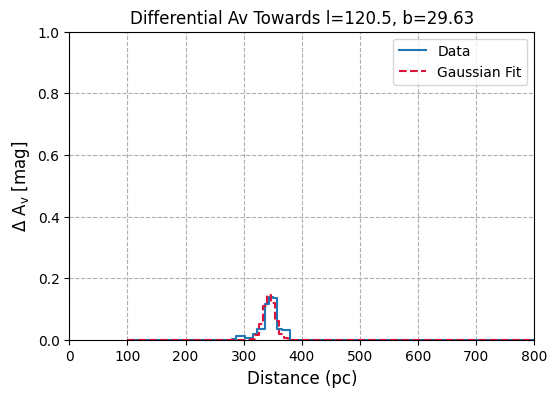

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,120.5,29.63,0.62,[347.47474747474746],10.345605,5.146000e+21,161.19936


In [11]:
plotred(120.5, 29.63)

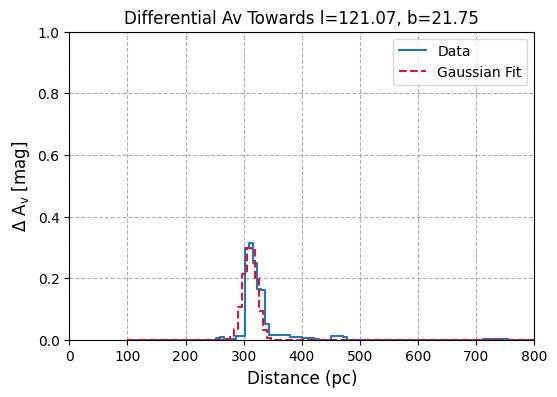

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,121.07,21.75,1.4725,[312.1212121212121],11.758286,1.222175e+22,336.851764


In [12]:
plotred(121.07, 21.75)

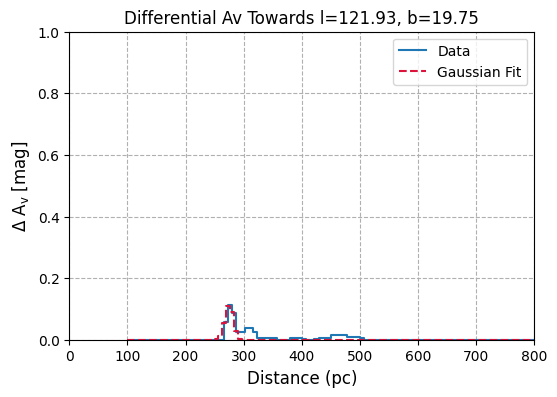

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,121.93,19.75,0.558,[276.7676767676768],7.454159,4.631400e+21,201.355304


In [13]:
plotred(121.93, 19.75)

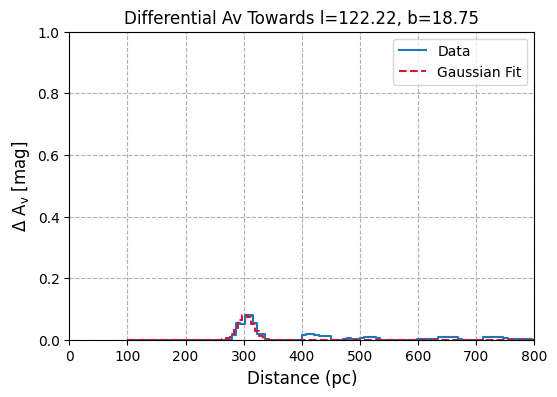

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,122.22,18.75,0.651,[312.1212121212121],13.174081,5.403300e+21,132.919346


In [14]:
plotred(122.22, 18.75)

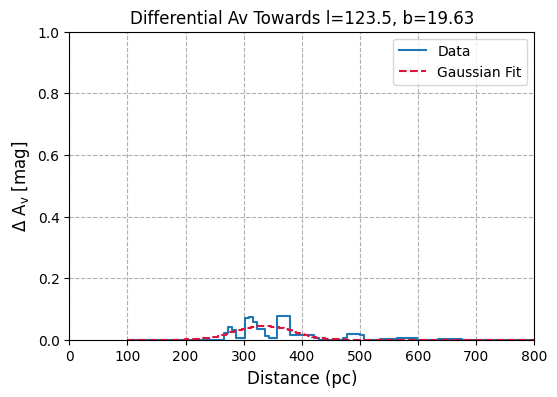

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,123.5,19.63,0.868,[368.6868686868687],48.663713,7.204400e+21,47.977988


In [15]:
plotred(123.5, 19.63)

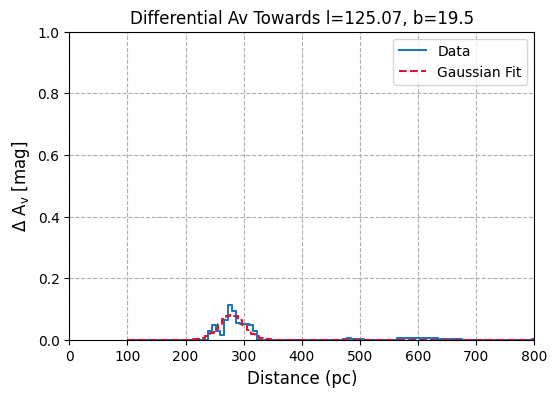

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.07,19.5,0.714916,[276.7676767676768],21.606231,5.933801e+21,89.002743


In [16]:
plotred(125.07, 19.5)

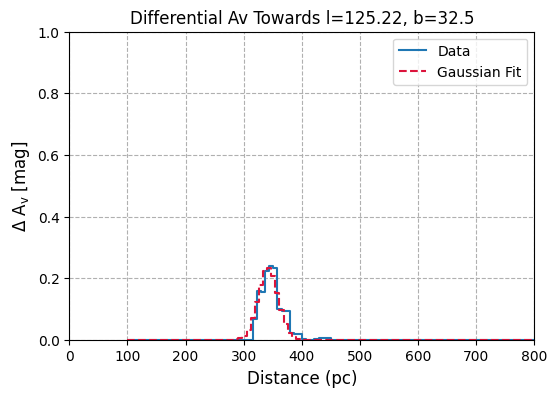

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.22,32.5,1.4415,[347.47474747474746],17.049214,1.196445e+22,227.424791


In [17]:
plotred(125.22, 32.5)

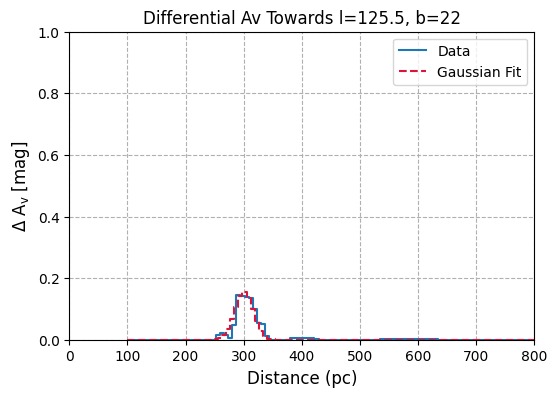

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.5,22,0.961,[290.9090909090909],15.925422,7.976300e+21,162.315501


In [18]:
plotred(125.5, 22)

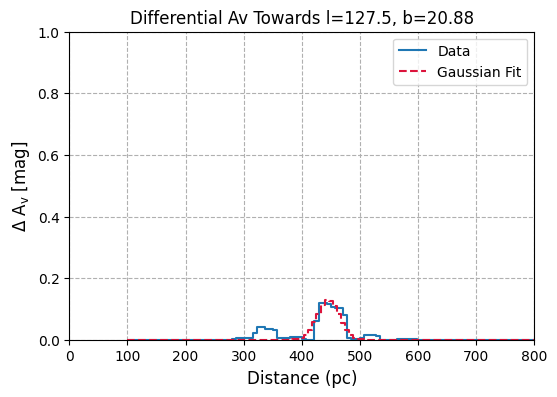

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,127.5,20.88,1.178,[432.32323232323233],18.853582,9.777400e+21,168.065653


In [19]:
plotred(127.5, 20.88)

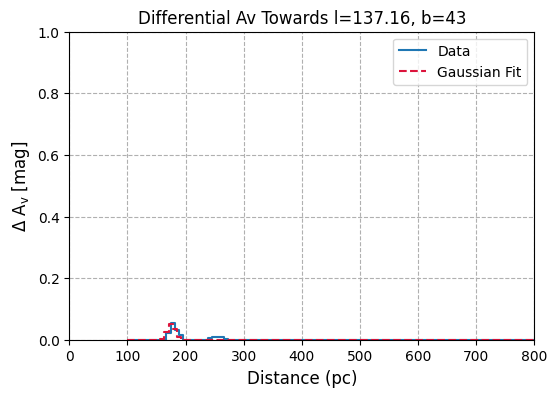

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,137.16,43,0.155,[177.77777777777777],6.567824,1.286500e+21,63.48012


In [20]:
plotred(137.16, 43)

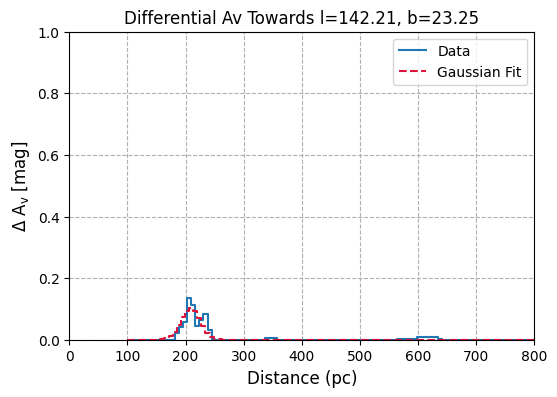

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,142.21,23.25,0.6665,[206.06060606060606],16.626771,5.531950e+21,107.825081


In [21]:
plotred(142.21, 23.25)

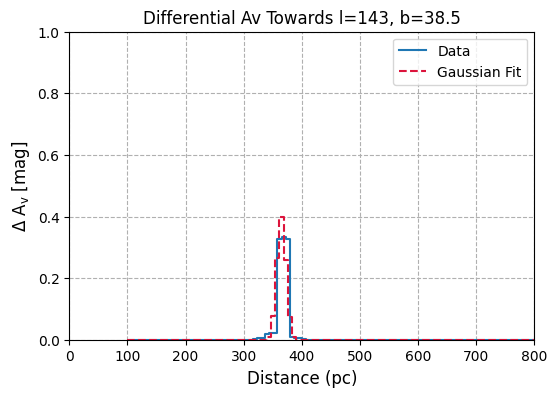

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,143,38.5,1.085,[368.6868686868687],7.726345,9.005500e+21,377.731499


In [22]:
plotred(143, 38.5)

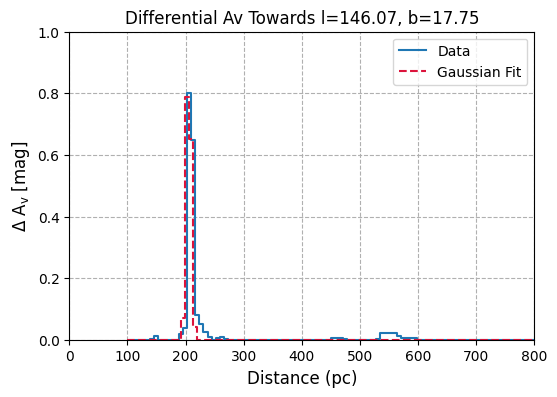

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.07,17.75,1.8445,[206.06060606060606],4.388298,1.530935e+22,1130.60287


In [23]:
plotred(146.07, 17.75, bounds = ([0, -180, 0], [1, 230, 50]))

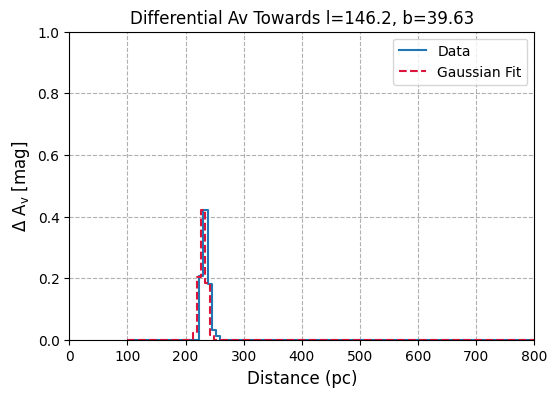

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.2,39.63,0.8525,[234.34343434343435],5.649858,7.075749e+21,405.867581


In [24]:
plotred(146.2, 39.63)

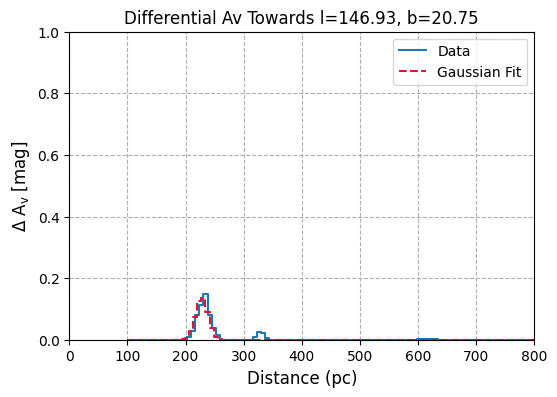

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.93,20.75,0.589,[234.34343434343435],10.36124,4.888700e+21,152.908317


In [25]:
plotred(146.93, 20.75)

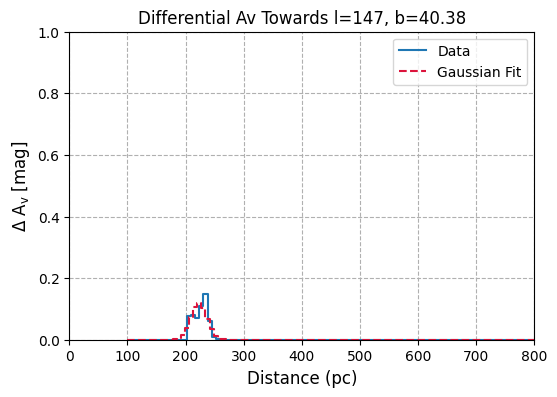

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,147,40.38,0.558,[234.34343434343435],13.734405,4.631400e+21,109.282823


In [26]:
plotred(147, 40.38)

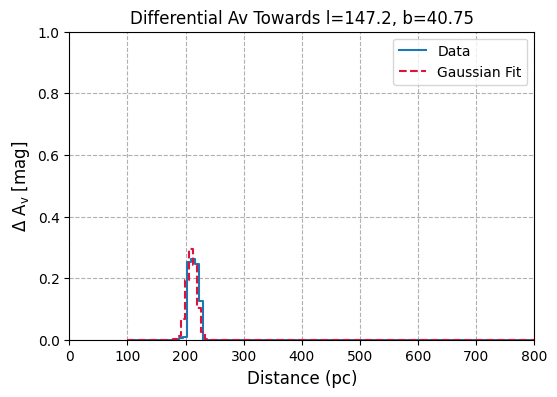

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,147.2,40.75,0.899,[213.13131313131314],8.876491,7.461700e+21,272.424338


In [27]:
plotred(147.2, 40.75)

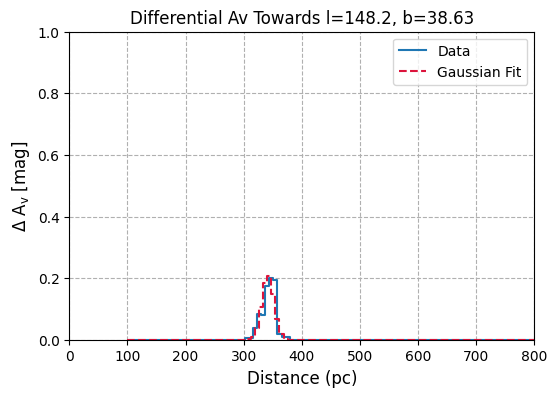

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,148.2,38.63,0.8215,[347.47474747474746],10.606255,6.818450e+21,208.340182


In [28]:
plotred(148.2, 38.63)

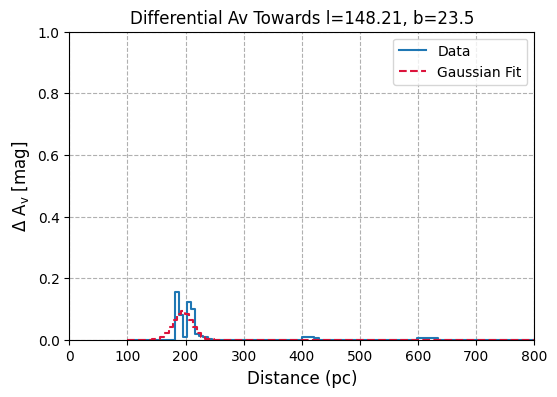

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,148.21,23.5,0.5735,[184.84848484848484],16.40651,4.760050e+21,94.025308


In [29]:
plotred(148.21, 23.5)

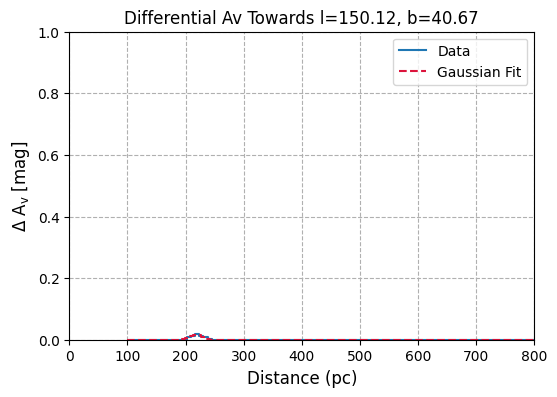

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,150.12,40.67,0.062,[220.2020202020202],10.849959,5.146000e+20,15.370611


In [30]:
plotred(150.12, 40.67)

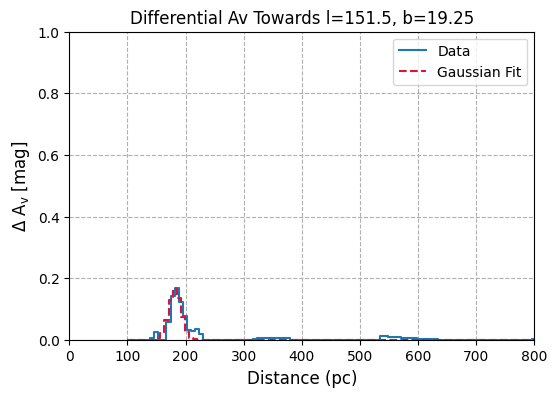

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,151.5,19.25,0.854416,[184.84848484848484],10.701703,7.091651e+21,214.755307


In [31]:
plotred(151.5, 19.25, bounds = ([0, 150, 0], [0.2, 220, 50]))

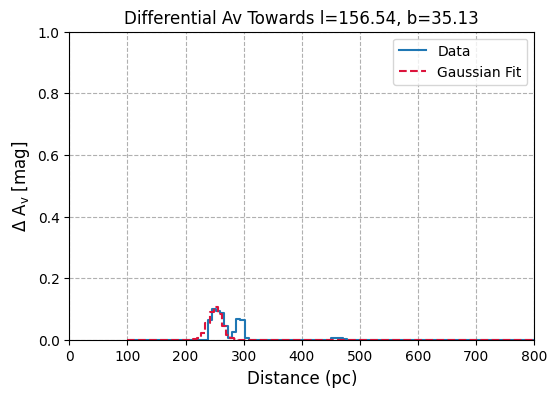

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,156.54,35.13,0.5735,[248.4848484848485],11.424673,4.760050e+21,135.025933


In [32]:
plotred(156.54, 35.13)

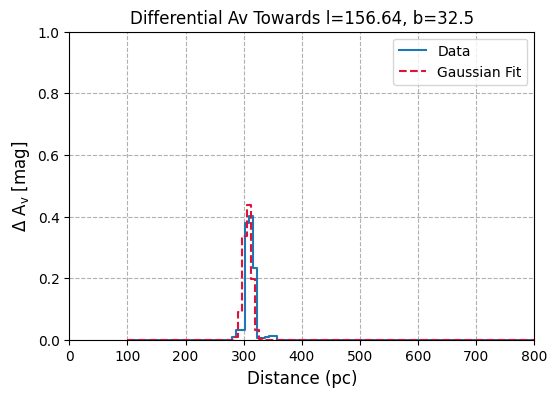

,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,156.64,32.5,1.1315,[312.1212121212121],6.866976,9.391450e+21,443.21715


In [33]:
plotred(156.64, 32.5)

# Creating master Bayestar CSV Table

In [34]:
from glob import glob

In [35]:
def csv_combine(folder = "B19 Mapped Dust Outputs", output = "B19 Master DF.csv"):
    #gather csvs
    csv_files = glob(os.path.join(folder, "*.csv"))
    
    # Load and concatenate only the first row of each CSV
    dfs = [pd.read_csv(i).iloc[[0]] for i in csv_files]  # use [[0]] to keep it as a DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Optionally drop any exact duplicate rows
    combined_df = combined_df.drop_duplicates()

    # Save out to master file
    combined_df.to_csv(os.path.join(folder, output), index=False)
    
    print(f"Combined {len(csv_files)} files into '{output}' with {len(combined_df)} rows.")
    return combined_df

In [36]:
folder = "B19 Mapped Dust Outputs"
output = "B19_Master_DF2.csv"

csv_combine(folder, output)

Combined 27 files into 'B19_Master_DF2.csv' with 26 rows.


,l,b,Max Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.22,32.50,1.441500,[347.47474747],17.049214,1.196445e+22,227.424791
1,146.07,17.75,1.844500,[206.06060606],4.388298,1.530935e+22,1130.602870
2,151.50,19.25,0.854416,[184.84848485],10.701703,7.091651e+21,214.755307
3,156.54,35.13,0.573500,[248.48484848],11.424673,4.760050e+21,135.025933
4,147.20,40.75,0.899000,[213.13131313],8.876491,7.461700e+21,272.424338
5,148.21,23.50,0.573500,[184.84848485],16.406510,4.760050e+21,94.025308
6,125.50,22.00,0.961000,[290.90909091],15.925422,7.976300e+21,162.315501
7,143.00,38.50,1.085000,[368.68686869],7.726345,9.005500e+21,377.731499
8,119.21,20.00,0.875663,[312.12121212],12.935086,7.268003e+21,182.093841
9,137.16,43.00,0.155000,[177.77777778],6.567824,1.286500e+21,63.480120
